# Web Log Anomaly Detection using Spark

Import modules

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Getting spark session

In [ ]:
spark = SparkSession.builder \
                    .master("spark://node-201:7077") \
                    .appName("Web Log Anomaly Detection using Spark") \
                    .config("spark.submit.deployMode", "client") \
                    .config("spark.executor.instances", "4") \
                    .config("spark.executor.memory", "8g") \
                    .config("spark.executor.cores", "8") \
                    .enableHiveSupport() \
                    .getOrCreate()

Getting spark context

In [ ]:
sc = spark.sparkContext

Apache Access Log Parser

In [ ]:
import re
from dateutil import parser
from pyspark.sql import Row

#APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)? ?(\S+)? ?(\S+)?" (\d{3}) ([\d-]+) ?"?([^"]+)?"? ?"?([^"]+)?"?'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] '
pattern = re.compile(APACHE_ACCESS_LOG_PATTERN)

def apache_access_log_parse(line):
    row = None

    try:
        m = pattern.match(line)

        time = m.group(4)
        time = parser.parse(time.replace(':', ' ', 1))

        #date = time.strftime('%Y%m%d')

        #size = m.group(9)
        #if size == '-': size = 0
        #else: size = long(size)

        row = Row(#host     = m.group(1),
                  #identity = m.group(2),
                  #user     = m.group(3),
                  time     = time)
                  #method   = m.group(5),
                  #url      = m.group(6),
                  #protocol = m.group(7),
                  #status   = m.group(8),
                  #size     = size,
                  #referer  = m.group(10),
                  #agent    = m.group(11),
                  #date     = date)
    except:
        print "apache access log parsing error : ", line

    return row

Loading data

In [ ]:
LOG_FILE_PATH = 'hdfs://node-201:9000/data/weblog/2015-1m'
rdd = sc.textFile(LOG_FILE_PATH) \
        .map(apache_access_log_parse) \
        .filter(lambda x: x is not None)
df = spark.createDataFrame(rdd)

데이터 확인

In [ ]:
df.show(10, False)

### 요청 건수의 변화

데이터 전처리

In [ ]:
#from pyspark.sql.functions import *
#col = unix_timestamp(df['time'], '%Y%m%d %H%M%S')#.cast('timestamp')
#request_cnt_df = df.withColumn('time', col).groupby('time').count().sort('time')
request_cnt_df = df.groupby('time').count().sort('time')
request_cnt_pdf = request_cnt_df.toPandas()
request_cnt_pdf = request_cnt_pdf.set_index('time')

In [7]:
request_cnt_pdf = pd.read_pickle('request_cnt.pkl')
#request_cnt_pdf.to_pickle('request_cnt.pkl')

데이터 확인

In [175]:
print request_cnt_pdf['count'].describe()
request_cnt_pdf.head(10)

count    20345.000000
mean        49.152077
std         29.025664
min          4.000000
25%         27.000000
50%         42.000000
75%         64.000000
max        236.000000
Name: count, dtype: float64


,count
time,
2015-12-11 05:30:01,30
2015-12-11 05:30:02,32
2015-12-11 05:30:03,81
2015-12-11 05:30:04,68
2015-12-11 05:30:05,53
2015-12-11 05:30:06,46
2015-12-11 05:30:07,31
2015-12-11 05:30:08,27
2015-12-11 05:30:09,58


데이터 시각화

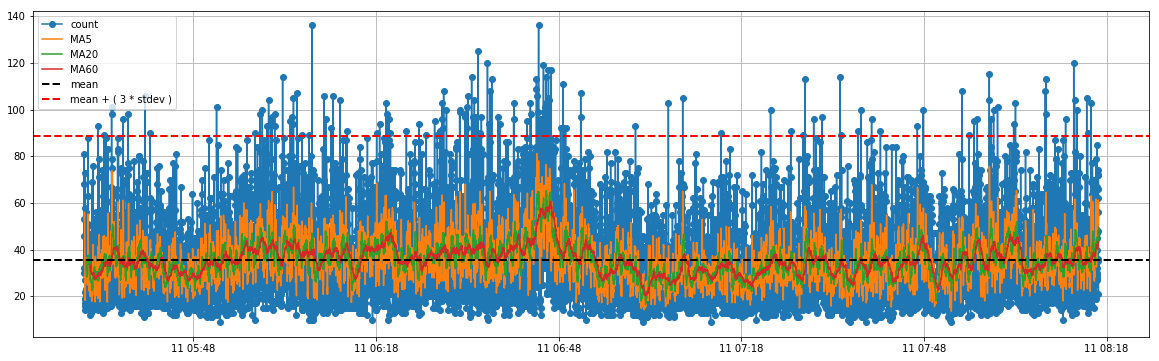

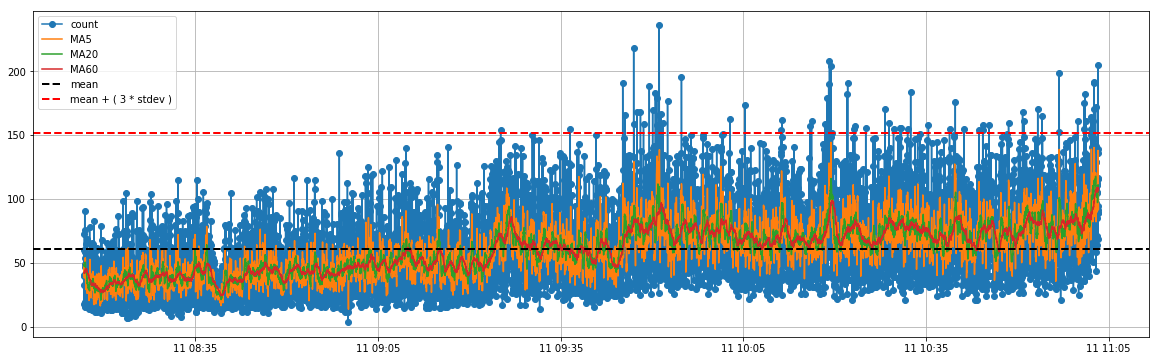

In [193]:
def plot(df, type='line'):
    mean = df['count'].mean()
    stdev = df['count'].std()
    x_max = df['count'].count()
    y_max = df['count'].max()
    
    major_xticks = np.arange(0, x_max, x_max/10)
    minor_xticks = np.arange(0, x_max, x_max/20)
    major_yticks = np.arange(0, y_max, y_max/5)
    minor_yticks = np.arange(0, y_max, y_max/10)

    if type == 'line':
        plt.figure(figsize=(20,6))
        plt.plot(df.index, df['count'], linestyle='solid', marker='o')
        plt.plot(df.index, df['MA5'], linestyle='solid')
        #plt.plot(df.index, df['MA10'], linestyle='solid')
        plt.plot(df.index, df['MA20'], linestyle='solid')
        #plt.plot(df.index, df['MA30'], linestyle='solid')
        plt.plot(df.index, df['MA60'], linestyle='solid')
        plt.axhline(y=mean, linewidth=2, color='black', linestyle='dashed', label='mean')
        plt.axhline(y=mean+(3*stdev), linewidth=2, color='red', linestyle='dashed', label='mean + ( 3 * stdev )')
    elif type == 'bar':
        ax = df.plot(figsize=(20,6), kind='bar', grid=True, rot=15)
        plt.axhline(y=mean, linewidth=2, color='black', linestyle='dashed', label='mean')
        plt.axhline(y=mean+(3*stdev), linewidth=2, color='red', linestyle='dashed', label='mean + ( 3 * stdev )')
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        ax.set_xticklabels(df.index[0:x_max:x_max/10])
        ax.set_yticklabels(major_yticks)
        ax.set_xticks(major_xticks)
        ax.set_xticks(minor_xticks, minor=True)
        ax.set_yticks(major_yticks)
        ax.set_yticks(minor_yticks, minor=True)

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot(request_cnt_pdf[0:10000], type='line')
plot(request_cnt_pdf[10000:20000], type='line')
#request_cnt_pdf[15600:15800]

In [174]:
request_cnt_pdf.sort_values(['count'], ascending=[False])[:10]

,count
time,
2015-12-11 09:51:11,236
2015-12-11 11:04:38,224
2015-12-11 11:08:54,222
2015-12-11 09:46:59,218
2015-12-11 11:04:30,216
2015-12-11 11:06:49,216
2015-12-11 10:19:09,208
2015-12-11 11:03:14,205
2015-12-11 10:19:23,204


이동 평균 추가

In [176]:
request_cnt_pdf['MA5'] = request_cnt_pdf['count'].rolling(5).mean()
request_cnt_pdf['MA10'] = request_cnt_pdf['count'].rolling(10).mean()
request_cnt_pdf['MA20'] = request_cnt_pdf['count'].rolling(20).mean()
request_cnt_pdf['MA30'] = request_cnt_pdf['count'].rolling(30).mean()
request_cnt_pdf['MA60'] = request_cnt_pdf['count'].rolling(60).mean()

In [177]:
request_cnt_pdf

,count,MA5,MA10,MA20,MA30,MA60
time,,,,,,
2015-12-11 05:30:01,30,NaN,NaN,NaN,NaN,NaN
2015-12-11 05:30:02,32,NaN,NaN,NaN,NaN,NaN
2015-12-11 05:30:03,81,NaN,NaN,NaN,NaN,NaN
2015-12-11 05:30:04,68,NaN,NaN,NaN,NaN,NaN
2015-12-11 05:30:05,53,52.8,NaN,NaN,NaN,NaN
2015-12-11 05:30:06,46,56.0,NaN,NaN,NaN,NaN
2015-12-11 05:30:07,31,55.8,NaN,NaN,NaN,NaN
2015-12-11 05:30:08,27,45.0,NaN,NaN,NaN,NaN
2015-12-11 05:30:09,58,43.0,NaN,NaN,NaN,NaN


### TODO : 슬라이딩 윈도우 적용. (표준편차 어떻게 응용할지.)
### TODO : 최적화. (윈도우 크기, 해상도, threshold 크기)
### TODO : 탐지 결과 보여주기.
### TODO : 평가.


### 클라이언트 수의 변화

### 응답 크기의 변화

예전 코드

In [ ]:
pdf['size'].plot()

In [ ]:
pdf['size'].hist()

In [ ]:
pdf['status'].hist()

In [ ]:
pdf.groupby('host')